## FSMContext в Aiogram 3
### Содержание ноутбука:
- Теория: Что такое FSMContext в Aiogram 3
- Пример использования FSMContext (опросник пользователя)
- Пример использования FSMContext для вывода вопросов из списка


- **FSMContext** в Aiogram 3 используется для управления состояниями в чат-ботах, что позволяет создавать более сложные и интерактивные сценарии взаимодействия с пользователями. FSM (Finite State Machine) или конечный автомат — это модель, которая помогает управлять переходами между различными состояниями в приложении. В контексте чат-ботов, FSM позволяет отслеживать, на каком этапе взаимодействия находится пользователь, и реагировать на его действия соответствующим образом. FSMContext предоставляет интерфейс для работы с состояниями, позволяя разработчикам легко определять и изменять текущее состояние пользователя.

- FSMContext в Aiogram 3 используется для хранения и изменения текущего состояния пользователя в процессе взаимодействия с ботом. Например, если бот проводит опрос, FSMContext может использоваться для отслеживания, на каком вопросе находится пользователь, и перехода к следующему вопросу после получения ответа. Это достигается за счет определения состояний и переходов между ними, что позволяет боту реагировать на ввод пользователя и изменять свое поведение в зависимости от текущего состояния. FSMContext также позволяет сохранять данные, связанные с текущим состоянием, что может быть полезно для временного хранения информации, необходимой для последующих шагов взаимодействия.

- Использование FSMContext в Aiogram 3 предоставляет несколько ключевых преимуществ. Во-первых, это упрощает управление сложными сценариями взаимодействия, позволяя разработчикам четко определять логику переходов между состояниями. Во-вторых, FSMContext способствует улучшению пользовательского опыта, так как бот может более точно и последовательно реагировать на действия пользователя. Наконец, FSMContext облегчает поддержку и расширение функциональности бота, так как логика состояний и переходов становится более структурированной и понятной. Это делает FSMContext важным инструментом для создания интерактивных и адаптивных чат-ботов на платформе Aiogram 3.

#### Состояния в FSMContext (Finite State Machine Context) позволяют контролировать, на каком этапе взаимодействия находится пользователь, сохраняя его текущий шаг в многошаговых сценариях. Например, когда бот последовательно запрашивает у пользователя ввод различных данных, FSM помогает отслеживать, что именно нужно запрашивать следующим, и автоматически переходить от одного состояния к другому.

#### Типы состояний FSM в Aiogram 3.x
В Aiogram состояние каждого пользователя представлено классом State, и разработчик сам определяет последовательность состояний. Типов состояний как таковых в Aiogram нет — вместо этого состояния можно представить как "шаги", которые задаются пользователем.

#### Создание и структура классов состояний
Для описания состояний создается класс, наследуемый от StatesGroup, в котором каждый этап обозначается атрибутом класса типа State. Пример:
```python
from aiogram.fsm.state import StatesGroup, State

class UserRegistration(StatesGroup):
    waiting_for_name = State()      # Пользователь вводит имя
    waiting_for_email = State()     # Пользователь вводит email
    waiting_for_phone = State()     # Пользователь вводит номер телефона
```
waiting_for_name, waiting_for_email, waiting_for_phone — это различные этапы (шаги) регистрации.

#### Установка начального состояния происходит с помощью команды установки состояния:
```python
await state.set_state(UserRegistration.waiting_for_name)
```
#### Изменение состояния происходит через метод set_state, где новое состояние задается следующим этапом. Например, при переходе от запроса имени к запросу email:
```python
await state.set_state(UserRegistration.waiting_for_email)
```
#### Очистка состояния возвращает пользователя в начальное состояние, убирая все временные данные, и происходит с помощью clear():
```python
await state.clear()
```

#### Важные методы для работы с состояниями

- set_state():
Устанавливает новое состояние, переводя пользователя на другой шаг.

- get_state():
Возвращает текущее состояние пользователя, что помогает определить, на каком этапе пользователь находится.

- clear():
Сбрасывает состояние, завершая сценарий и удаляя временные данные.

- update_data() и get_data():
Используются для сохранения и получения временных данных в процессе взаимодействия. Это важно, когда необходимо запоминать данные, которые пользователь вводил на предыдущих шагах. Пример:
```python
await state.update_data(name=message.text)  # Сохраняем имя
data = await state.get_data() # Получаем данные
name = data['name']
```

In [ ]:
#@title Загрузка и установка библиотек
%pip install -q -U aiogram==3.13.1

import asyncio
import os
from aiogram import Bot, Dispatcher, F
from aiogram.types import (Message, CallbackQuery, ReplyKeyboardMarkup, KeyboardButton,
                           InlineKeyboardMarkup, InlineKeyboardButton, BotCommand, ReplyKeyboardRemove)
from aiogram.utils.keyboard import ReplyKeyboardBuilder, InlineKeyboardBuilder
from aiogram.filters import Command
from aiogram.fsm.context import FSMContext
from aiogram.fsm.storage.memory import MemoryStorage
from aiogram.fsm.state import StatesGroup, State
import os


# Активируем поддержку асинхронных циклов (только для Colab)
# Google Colab не поддерживает обычный асинхронный цикл напрямую, из-за чего используется nest_asyncio
import nest_asyncio
nest_asyncio.apply()

# Токен из секретов Colab
from google.colab import userdata
TELEGRAM_TOKEN = userdata.get("TELEGRAM_TOKEN")

# Использование FSMContext
- Бот спрашивает пользователя его имя, возраст и любимый цвет. Каждое действие пользователя приводит к смене состояния, что позволяет контролировать сценарий.

In [ ]:
#@title Код и запуск бота

# Инициализация бота с токеном и диспетчера
bot = Bot(token=TELEGRAM_TOKEN)
dp = Dispatcher(storage=MemoryStorage())

# Класс состояний для управления этапами ------------------------------------------
class UserInfo(StatesGroup):
    waiting_for_name = State()      # Состояние ожидания имени
    waiting_for_age = State()       # Состояние ожидания возраста
    waiting_for_color = State()     # Состояние ожидания любимого цвета
# ---------------------------------------------------------------------------------

# Команда /start начинает взаимодействие и переводит пользователя в первое состояние
@dp.message(Command("start"))
async def start_command(message: Message, state: FSMContext):
    # Создаем Reply клавиатуру с кнопкой "Пропустить"
    keyboard = ReplyKeyboardBuilder()
    keyboard.button(text="Пропустить")
    keyboard.adjust(1)  # Одна кнопка в ряд

    # Отправляем приветственное сообщение и просим ввести имя
    await message.answer("Привет! Как вас зовут?",
                         reply_markup=keyboard.as_markup(resize_keyboard=True,
                                                         one_time_keyboard=True))
    # Устанавливаем состояние ожидания имени
    await state.set_state(UserInfo.waiting_for_name)

# Обработчик для получения имени пользователя
@dp.message(UserInfo.waiting_for_name)
async def get_name(message: Message, state: FSMContext):
    # Сохраняем имя пользователя в данные состояния
    await state.update_data(name=message.text)
    # Убираем клавиатуру после ввода
    await message.answer("Спасибо! Теперь введите ваш возраст.",
                         reply_markup=ReplyKeyboardRemove())
    # Устанавливаем состояние ожидания возраста
    await state.set_state(UserInfo.waiting_for_age)

# Обработчик для получения возраста пользователя
@dp.message(UserInfo.waiting_for_age)
async def get_age(message: Message, state: FSMContext):
    # Сохраняем возраст пользователя
    await state.update_data(age=message.text)

    # Создаем Inline клавиатуру для выбора цвета
    color_keyboard = InlineKeyboardBuilder()
    color_keyboard.button(text="Синий", callback_data="blue")
    color_keyboard.button(text="Красный", callback_data="red")
    color_keyboard.button(text="Зеленый", callback_data="green")
    color_keyboard.adjust(1)  # Одна кнопка в ряд

    # Просим пользователя выбрать любимый цвет
    await message.answer("Отлично! Теперь выберите ваш любимый цвет:",
                         reply_markup=color_keyboard.as_markup())
    # Устанавливаем состояние ожидания выбора цвета
    await state.set_state(UserInfo.waiting_for_color)

# Обработчик для выбора цвета с использованием Inline-клавиатуры
@dp.callback_query(F.data.in_(['blue', 'red', 'green']))
async def get_color(callback_query: CallbackQuery, state: FSMContext):
    # Проверяем, что текущее состояние — `waiting_for_color`
    current_state = await state.get_state()
    if current_state == UserInfo.waiting_for_color.state:
        # Определяем цвет на основе callback_data
        color = callback_query.data  # Получаем цвет (blue, red или green)

        # Сохраняем цвет пользователя в данные состояния
        await state.update_data(color=color)

        # Получаем все сохраненные данные
        user_data = await state.get_data()
        name = user_data.get("name", "Не указано")
        age = user_data.get("age", "Не указано")
        color = user_data.get("color", "Не указано")

        # Отправляем пользователю собранную информацию
        await callback_query.message.answer(
            f"Спасибо! Вот ваша информация:\n"
            f"Имя: {name}\n"
            f"Возраст: {age}\n"
            f"Любимый цвет: {color.capitalize()}"
        )

        # Закрываем callback-запрос
        await callback_query.answer()

        # Очищаем состояние после завершения опроса
        await state.clear()


# Запуска бота
async def main():
    try:
        print("Запуск бота...")
        await dp.start_polling(bot)
    finally:
        print("Остановка бота...")
        await bot.session.close()


if __name__ == "__main__":
    asyncio.run(main())  # Запускаем асинхронную основную функцию, которая инициирует работу бота


Запуск бота...


Остановка бота...


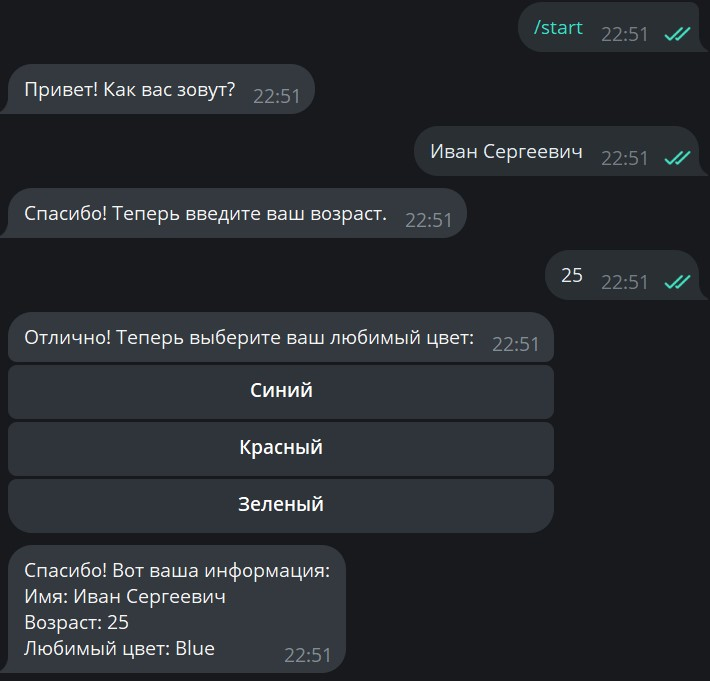

# Использование FSMContext для вывода вопросов из списка Python
- Бот, после ввода пользователем команды /start, по очереди задаст пользователю вопросы из списка.

In [ ]:
#@title Код и запуск бота

# Прежде чем запустить ячейку с ботом, остановите ячейку выше, т.к. бот в ячейке использует
# такой же TELEGRAM_TOKEN, как и бот из ячейки выше.

# Бот по очереди задаст пользователю вопросы из списка:
questions = ["Как вас зовут?",
             "Сколько вам лет?",
             "Какой ваш любимый цвет?"]

# Создаем объект бота и диспетчер
bot = Bot(token=TELEGRAM_TOKEN)
dp = Dispatcher(storage=MemoryStorage())

# Класс состояний --------------------------------------------------
class QuizStates(StatesGroup):
    asking_question = State()  # Состояние для вопроса
# ------------------------------------------------------------------


# Обработчик команды /start
@dp.message(Command("start"))
async def start_quiz(message: Message, state: FSMContext):
    # Инициализируем данные: начинаем с первого вопроса и пустого списка ответов
    await state.update_data(current_question=0, answers=[])
    # Задаем первый вопрос, вызывая функцию ask_next_question
    await ask_next_question(message, state)


# Функция для задания следующего вопроса
async def ask_next_question(message: Message, state: FSMContext):
    # Получаем текущие данные из состояния FSM
    data = await state.get_data()
    # Извлекаем индекс текущего вопроса; по умолчанию 0
    current_question_index = data.get("current_question", 0)

    # Если есть еще вопросы, задаем следующий
    if current_question_index < len(questions):
        # Получаем текст вопроса по текущему индексу и отправляем его пользователю
        await message.answer(questions[current_question_index])
        # Устанавливаем состояние ожидания ответа на текущий вопрос
        await state.set_state(QuizStates.asking_question)
    else:
        # Если вопросов больше нет, завершаем опрос
        answers = data.get("answers", [])  # Получаем список всех ответов
        # Отправляем пользователю сообщение с результатами опроса
        await message.answer(f"Спасибо за ответы! Вот ваши ответы:\n" + "\n".join(answers))
        await state.clear()  # Очищаем состояние FSM


# Обработчик ответа
@dp.message(QuizStates.asking_question)
async def process_answer(message: Message, state: FSMContext):
    # Получаем текущие данные из состояния FSM
    data = await state.get_data()
    # Добавляем новый ответ в список ответов
    answers = data.get("answers", []) + [message.text]

    # Обновляем индекс следующего вопроса и сохраняем обновленный список ответов
    await state.update_data(current_question=data.get("current_question", 0) + 1, answers=answers)

    # Отладочное сообщение после ответа пользователя
    print(f"Получен ответ: {message.text}")
    print(f"Переход к индексу (номеру) вопроса: {data.get('current_question', 0) + 1}\n")

    # Задаем следующий вопрос, вызывая функцию ask_next_question
    await ask_next_question(message, state)


# Запуск бота ------------------------------
async def main():
    try:
        print("Запуск бота...")
        await dp.start_polling(bot)
    finally:
        print("Остановка бота...")
        await bot.session.close()

if __name__ == "__main__":
    asyncio.run(main())


Запуск бота...
Получен ответ: Иван Сергеевич
Переход к индексу (номеру) вопроса: 1

Получен ответ: 25
Переход к индексу (номеру) вопроса: 2

Получен ответ: зеленый
Переход к индексу (номеру) вопроса: 3



Остановка бота...


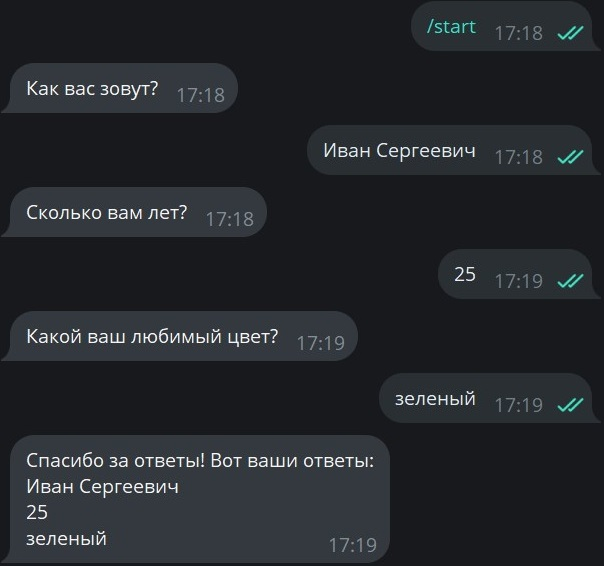